# Calculate the disturbance, the free-air anomaly, and their difference

Here, we'll load the raw gravity and topography data downloaded from the [ICGEM Calculation Service](http://icgem.gfz-potsdam.de) and calculate the anomaly, the disturbance, and their difference. For all calculations, we'll use the WGS84 ellipsoid as the Normal Earth.

## Jupyter notebooks

This is a [Jupyter notebook](http://jupyter.org/). It's an interactive computing environment where you can mix text (like this), code, figures, video, etc. The notebook is organized into cells. This is a Markdown cell (click on it to see the source) and it can contain text, hyperlinks, images, and even Latex equations. Other cells contain source code and the output of the code. 

To execute a code cell, select it and type `shift+enter` or click on the *Run button* above. This will run the code and produce it's output. Make sure to run the cells in order first. You can alter the code in a cell and run it again to see what changed.

## Load the required libraries

These are the open-source libraries that we'll use in this notebook. You can safely ignore any warnings (text with red background) that pops up at this point.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
# for the gravity corrections
from fatiando.gravmag import normal_gravity
# Load our custom helper functions from helpers.py
from helpers import plot_field, minmax, load_icgem_gdf

/home/leo/miniconda3/envs/use-the-disturbance/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


## Loading the data and converting to an xarray grid

The data are laid out in regular grids but ICGEM makes them available in a text format. That's not very efficient for computation or storage. Plus, for each location we have 3 different files: the raw gravity (with the measurement height), the geoid, and the ETOPO1 topography. We can use an [`xarray.Dataset`](http://xarray.pydata.org/en/stable/data-structures.html#dataset) to store all of these grids in a single variable. We'll use the helper function `load_icgem_gdf` to load the data in a ICGEM `.gdf` file and store it in an `xarray.Dataset`.

We need to load each dataset (gravity, geoid, topography) and combine them into a single `Dataset`.

In [2]:
data = xr.merge([load_icgem_gdf('../data/eigen-6c4-gravity.tar.gz'), 
                 load_icgem_gdf('../data/eigen-6c4-geoid.tar.gz'), 
                 load_icgem_gdf('../data/etopo1.tar.gz')])
data

<xarray.Dataset>
Dimensions:         (latitude: 901, longitude: 1801)
Coordinates:
  * latitude        (latitude) float64 -90.0 -89.8 -89.6 -89.4 -89.2 -89.0 ...
  * longitude       (longitude) float64 -180.0 -179.8 -179.6 -179.4 -179.2 ...
Data variables:
    gravity_earth   (latitude, longitude) float64 9.823e+05 9.823e+05 ...
    h_over_geoid    (latitude, longitude) float64 2.745e+03 2.745e+03 ...
    geoid           (latitude, longitude) float64 -29.5 -29.5 -29.5 -29.5 ...
    topography_shm  (latitude, longitude) float64 2.763e+03 2.763e+03 ...

Plot the loaded data using a Robinson projection.

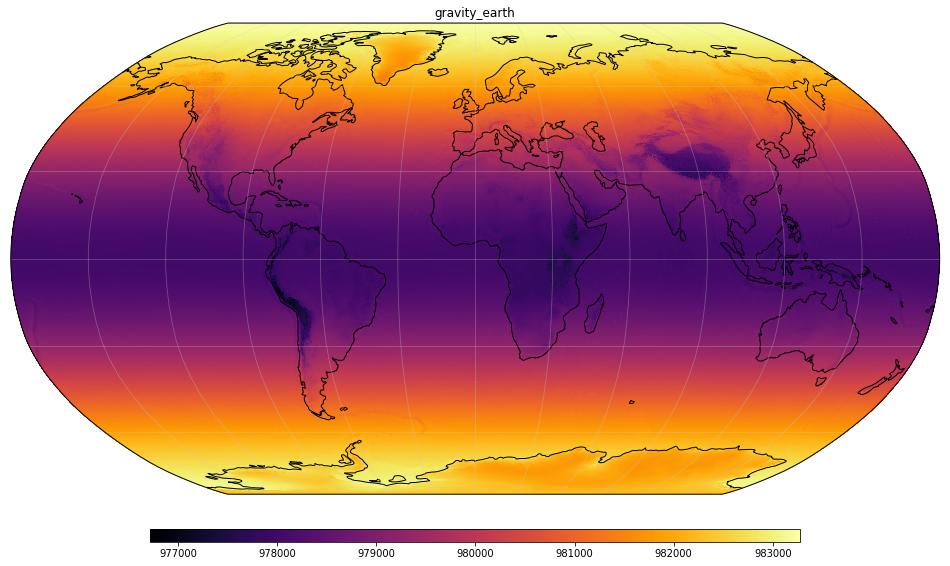

In [3]:
fig = plt.figure(figsize=(13, 16))
ax = plt.axes(projection=ccrs.Robinson())
plot_field(ax, data, 'gravity_earth', cmap='inferno')
plt.tight_layout(pad=0)

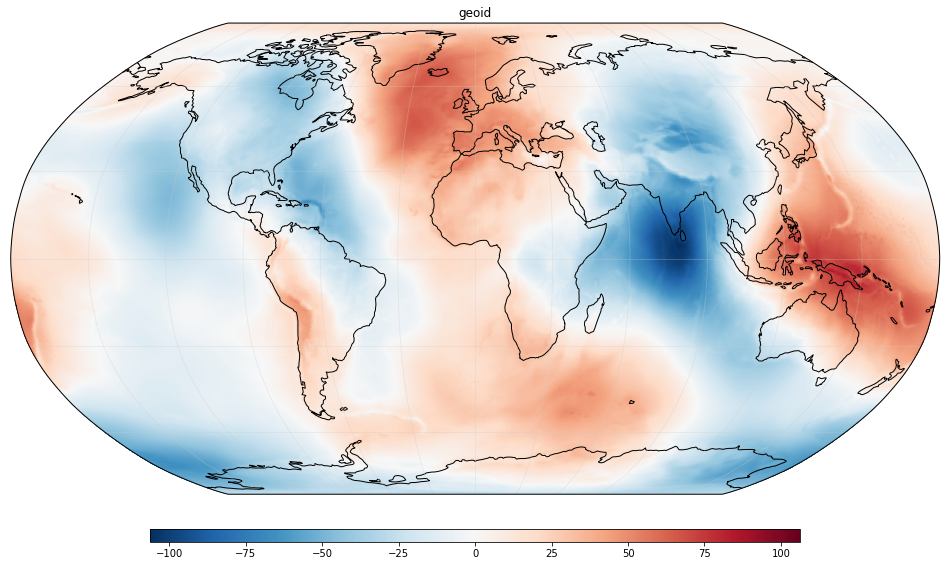

In [4]:
fig = plt.figure(figsize=(13, 16))
ax = plt.axes(projection=ccrs.Robinson())
plot_field(ax, data, 'geoid', cmap='RdBu_r')
plt.tight_layout(pad=0)

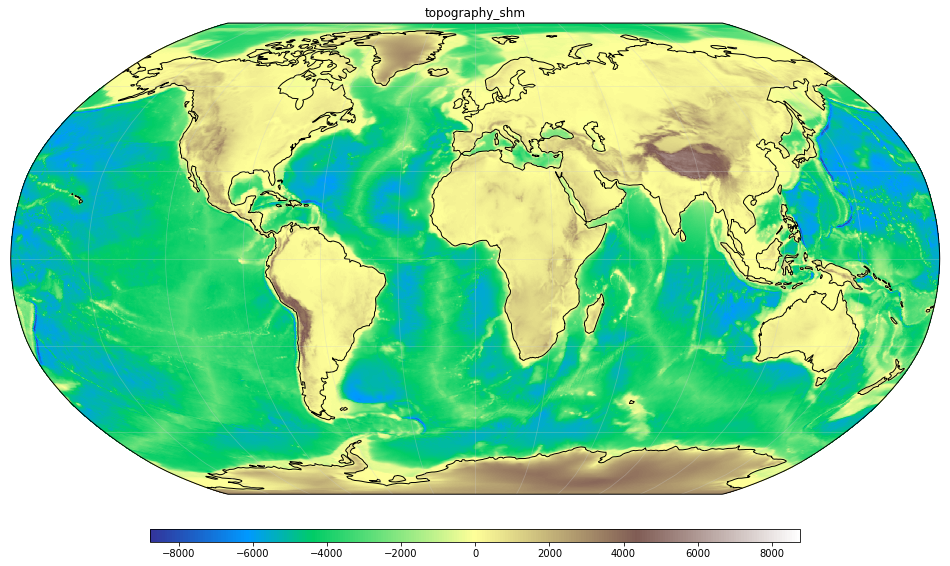

In [5]:
fig = plt.figure(figsize=(13, 16))
ax = plt.axes(projection=ccrs.Robinson())
plot_field(ax, data, 'topography_shm', cmap='terrain')
plt.tight_layout(pad=0)

## Calculate geometric heights

The heights and topography provided by ICGEM are all referenced to the geoid (orthometric heights). We must convert them to geometric heights (referenced to the ellipsoid) by adding the geoidal height:

$$
h \approx N + H
$$

In [6]:
data['h_over_ellipsoid'] = data.h_over_geoid + data.geoid
data['topography_ell'] = data.topography_shm + data.geoid

It's important to note that `h_over_geoid` and `h_over_ellipsoid` refer to the observation height of the gravity measurements while `topography_shm` and `topography_ell` are topographic and bathimetric heights with respect to the geoid and ellipsoid, respectively.

## Gravity disturbance

We'll calculate the gravity disturbance:

$$
\delta g_P = g_P - \gamma_P \approx g_P - \left(\gamma_Q - 0.3086 h_P\right)
$$

in which $g_P$ is the gravity measured at P, $\gamma_P$ is the normal gravity calculated at P, $\gamma_Q$ is the normal gravity calculate on the ellipsoid, and $h_P$ is the geometric height of point P. We'll use the Somigliana formula (Hofmann-Wellenhof and Moritz, 2005) for $\gamma_Q$.

In [7]:
gamma_p = normal_gravity.gamma_somigliana(data.latitude) - 0.3086*data.h_over_ellipsoid
data['disturbance'] = data.gravity_earth - gamma_p

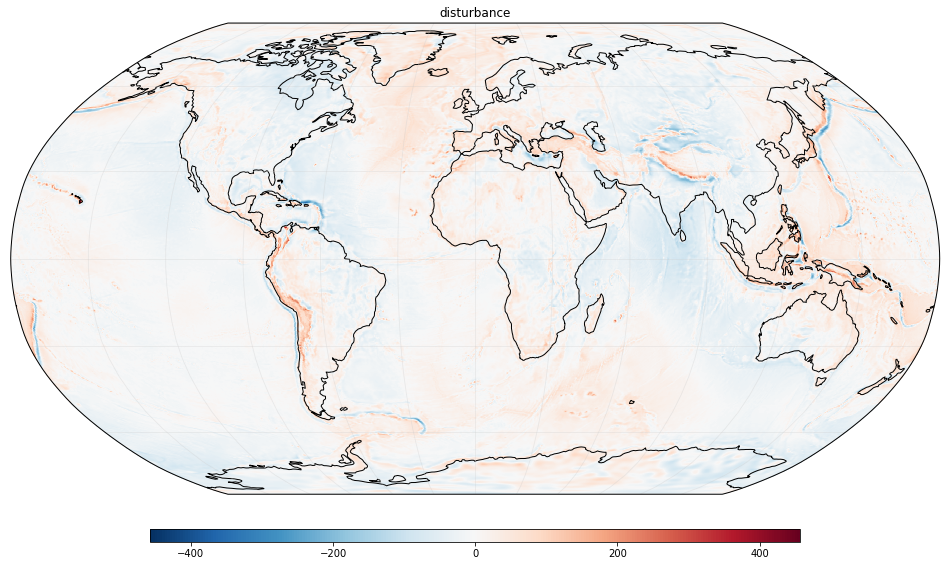

In [8]:
fig = plt.figure(figsize=(13, 16))
ax = plt.axes(projection=ccrs.Robinson())  
plot_field(ax, data, 'disturbance', cmap='RdBu_r')
plt.tight_layout(pad=0)

## Free-air anomaly

Next, we calculate the free-air anomaly:

$$
\Delta g^F = \left(g_P + 0.3086 H_P\right) - \gamma_Q
$$

in which $H_P$ is the orthometric height of the observation point and $\gamma_Q$ is the normal gravity calculated on the surface of the ellipsoid.

In [9]:
gamma_q = normal_gravity.gamma_closed_form(data.latitude, height=0)
data['freeair'] = (data.gravity_earth + 0.3086*data.h_over_geoid) - gamma_q

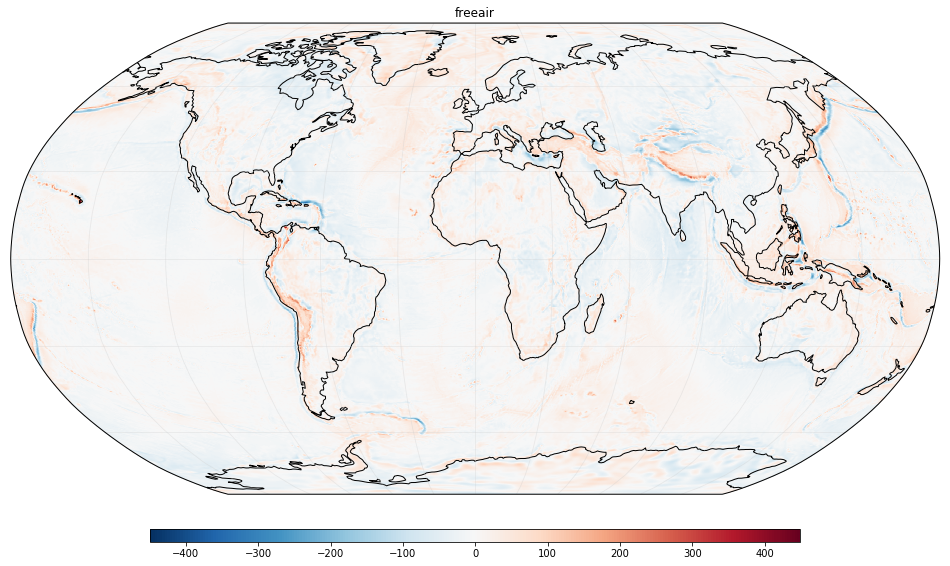

In [10]:
fig = plt.figure(figsize=(13, 16))
ax = plt.axes(projection=ccrs.Robinson())  
plot_field(ax, data, 'freeair', cmap='RdBu_r')
plt.tight_layout(pad=0)

## Difference

Finally, calculate the difference between the disturbance and the free-air anomaly.

In [11]:
data['difference'] = np.abs(data.disturbance - data.freeair)

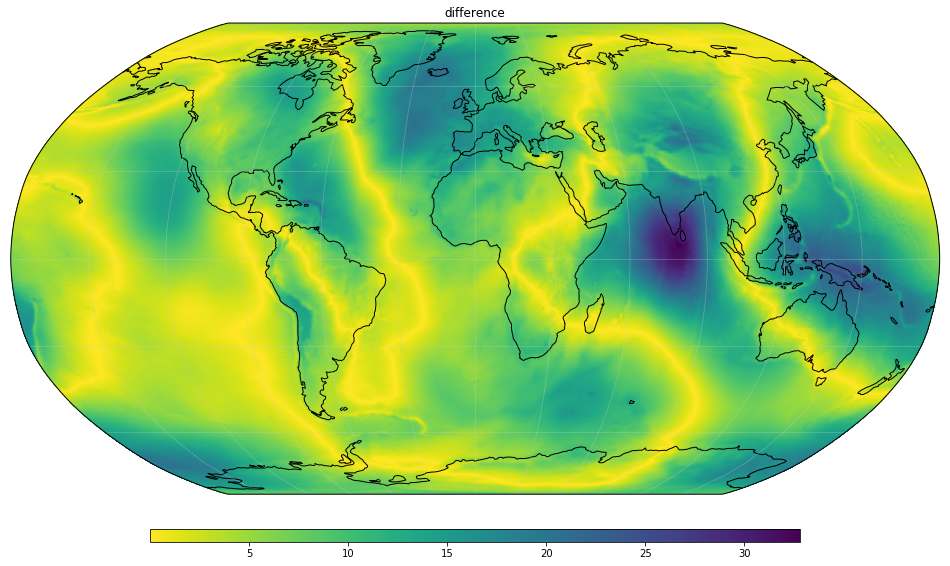

In [12]:
fig = plt.figure(figsize=(13, 16))
ax = plt.axes(projection=ccrs.Robinson())  
plot_field(ax, data, 'difference', cmap='viridis_r')
plt.tight_layout(pad=0)

## Save to a netCDF file

Now we can save the data grids to netCDF.

In [14]:
data.difference.to_netcdf('../data/disturbance-anomaly-difference.nc', mode='w')